<a href="https://colab.research.google.com/github/ryansilvatrb/Transfer_learning_fine-tuning/blob/main/notebooks/transfer-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning

This tutorial will guide you through the process of using _transfer learning_ to learn an accurate image classifier from a relatively small number of training samples. Generally speaking, transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model.

More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task. This method has become popular in recent years to improve the performance of a neural net trained on a small dataset; the intuition is that the new dataset may be too small to train to good performance by itself, but we know that most neural nets trained to learn image features often learn similar features anyway, especially at early layers where they are more generic (edge detectors, blobs, and so on).

Transfer learning has been largely enabled by the open-sourcing of state-of-the-art models; for the top performing models in image classification tasks (like from [ILSVRC](http://www.image-net.org/challenges/LSVRC/)), it is common practice now to not only publish the architecture, but to release the trained weights of the model as well. This lets amateurs use these top image classifiers to boost the performance of their own task-specific models.

#### Feature extraction vs. fine-tuning

At one extreme, transfer learning can involve taking the pre-trained network and freezing the weights, and using one of its hidden layers (usually the last one) as a feature extractor, using those features as the input to a smaller neural net.

At the other extreme, we start with the pre-trained network, but we allow some of the weights (usually the last layer or last few layers) to be modified. Another name for this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much.

Sometimes, we do something in-between: Freeze just the early/generic layers, but fine-tune the later layers. Which strategy is best depends on the size of your dataset, the number of classes, and how much it resembles the dataset the previous model was trained on (and thus, whether it can benefit from the same learned feature extractors). A more detailed discussion of how to strategize can be found in [[1]](http://cs231n.github.io/transfer-learning/) [[2]](http://sebastianruder.com/transfer-learning/).

## Procedure

In this guide will go through the process of loading a state-of-the-art, 1000-class image classifier, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) which [won the ImageNet challenge in 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), and using it as a fixed feature extractor to train a smaller custom classifier on our own images, although with very few code changes, you can try fine-tuning as well.

We will first load VGG16 and remove its final layer, the 1000-class softmax classification layer specific to ImageNet, and replace it with a new classification layer for the classes we are training over. We will then freeze all the weights in the network except the new ones connecting to the new classification layer, and then train the new classification layer over our new dataset.

We will also compare this method to training a small neural network from scratch on the new dataset, and as we shall see, it will dramatically improve our accuracy. We will do that part first.

As our test subject, we'll use a dataset consisting of around 6000 images belonging to 97 classes, and train an image classifier with around 80% accuracy on it. It's worth noting that this strategy scales well to image sets where you may have even just a couple hundred or less images. Its performance will be lesser from a small number of samples (depending on classes) as usual, but still impressive considering the usual constraints.


1. Imports URL

In [7]:
import os
import zipfile
import tensorflow as tf

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=False)  # primeiro sem extrair

# Extrai manualmente
import zipfile
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(path_to_zip))

# Caminhos corretos
base_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Verifica se existe
print("Train dir exists:", os.path.exists(train_dir))
print("Validation dir exists:", os.path.exists(validation_dir))


Train dir exists: True
Validation dir exists: True


### Getting a dataset

The first step is going to be to load our data. As our example, we will be using the dataset [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains around 9000 labeled images belonging to 101 object categories. However, we will exclude 5 of the categories which have the most images. This is in order to keep the class distribution fairly balanced (around 50-100) and constrained to a smaller number of images, around 6000.

To obtain this dataset, you can either run the download script `download.sh` in the `data` folder, or the following commands:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz

If you wish to use your own dataset, it should be aranged in the same fashion to `101_ObjectCategories` with all of the images organized into subfolders, one for each class. In this case, the following cell should load your custom dataset correctly by just replacing `root` with your folder. If you have an alternate structure, you just need to make sure that you load the list `data` where every element is a dict where `x` is the data (a 1-d numpy array) and `y` is the label (an integer). Use the helper function `get_image(path)` to load the image correctly into the array, and note also that the images are being resized to 224x224. This is necessary because the input to VGG16 is a 224x224 RGB image. You do not need to resize them on your hard drive, as that is being done in the code below.

If you have `101_ObjectCategories` in your data folder, the following cell should load all the data.

3. Criar os ImageDataGenerator:

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


4. Construindo o modelo (Transfer Learning)

In [9]:
# Carrega MobileNetV2 pré-treinado no ImageNet
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')

# Congela camadas do modelo base
base_model.trainable = False

# Adiciona camadas finais
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

5. Treinamento inicial

In [10]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 689ms/step - accuracy: 0.6564 - loss: 0.6456 - val_accuracy: 0.9400 - val_loss: 0.1878
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.9002 - loss: 0.2561 - val_accuracy: 0.9560 - val_loss: 0.1296
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.9095 - loss: 0.2114 - val_accuracy: 0.9630 - val_loss: 0.1114
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - accuracy: 0.9461 - loss: 0.1480 - val_accuracy: 0.9540 - val_loss: 0.1144
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 270ms/step - accuracy: 0.9314 - loss: 0.1609 - val_accuracy: 0.9610 - val_loss: 0.0983


6. Fine-tuning (ajustando camadas finais do MobileNetV2)

In [11]:
# Descongela últimas 50 camadas da base
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 576ms/step - accuracy: 0.7726 - loss: 0.5030 - val_accuracy: 0.9670 - val_loss: 0.0876
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - accuracy: 0.9036 - loss: 0.2323 - val_accuracy: 0.9660 - val_loss: 0.0873
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.9185 - loss: 0.2021 - val_accuracy: 0.9660 - val_loss: 0.0848
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.9122 - loss: 0.2074 - val_accuracy: 0.9680 - val_loss: 0.0808
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.9266 - loss: 0.1737 - val_accuracy: 0.9680 - val_loss: 0.0780


7. Avaliação

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9666 - loss: 0.0824
Acurácia no conjunto de validação: 96.80%


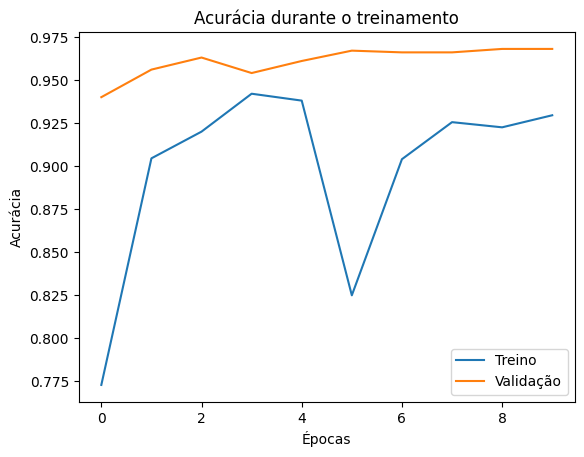

In [12]:
loss, acc = model.evaluate(validation_generator)
print(f"Acurácia no conjunto de validação: {acc*100:.2f}%")

# Plotando curvas
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Acurácia durante o treinamento')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'])
plt.show()

8. Salvando modelo

In [13]:
model.save("cats_vs_dogs_transfer_learning.h5")